In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
from matplotlib import image

# read path images
data_path = "./dataset/"
imagePaths = list(paths.list_images(data_path))
imagePaths[:10]

['./dataset/with mask\\10.png',
 './dataset/with mask\\100.png',
 './dataset/with mask\\1004.png',
 './dataset/with mask\\1005.png',
 './dataset/with mask\\1006.png',
 './dataset/with mask\\1007.png',
 './dataset/with mask\\1008.png',
 './dataset/with mask\\1011.png',
 './dataset/with mask\\1012.png',
 './dataset/with mask\\1018.png']

In [3]:
images =[]
labels = []
for i in imagePaths[-2000:]+imagePaths[:2000]:
    # lấy label từ path ví dụ : ./dataset/with mask\\1012.png' => label = 'with mask'
    label = i.split(os.path.sep)[-2]
    labels.append(label)

    image = load_img(i,target_size=(224,224)) # resize size 
    image = img_to_array(image)  
    images.append(image)

# mã hóa dữ liệu thành định dạng numpy
images = np.array(images,dtype='float32')
labels  =np.array(labels)


In [4]:
images.shape

(4000, 224, 224, 3)

In [5]:
labels.shape

(4000,)

In [6]:
# mã hóa labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = tf.keras.utils.to_categorical(labels)

In [7]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(images,labels,test_size=0.5,stratify=labels,random_state=0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X,test_Y,test_size=0.8,stratify=test_Y,random_state=0)

In [9]:
print(f"train_X :{train_X.shape} train_Y:{train_Y.shape}")
print(f"val_X :{val_X.shape} val_Y:{val_Y.shape}")
print(f"test_X :{test_X.shape} test_Y:{test_Y.shape}")

train_X :(2000, 224, 224, 3) train_Y:(2000, 2)
val_X :(400, 224, 224, 3) val_Y:(400, 2)
test_X :(1600, 224, 224, 3) test_Y:(1600, 2)


In [10]:
# tăng cường dữ liệu
aug = ImageDataGenerator(
    rotation_range = 20,  # xoay anh
    zoom_range = 0.15, # zoom anh
    width_shift_range = 0.2, # dich anh theo chieu ngang
    height_shift_range =0.2, # dich anh theo chieu doc
    shear_range = 0.15, # lam meo anh
    horizontal_flip = True, # lat  hinh theo chieu doc
    vertical_flip = True, # lat hinh theo chieu ngang
    fill_mode = 'nearest'
)

In [11]:
# Sử dụng mô hình EfficientNet là mô hình cơ sở 
baseModel = tf.keras.applications.EfficientNetB0(include_top=False,weights='imagenet',input_tensor=tf.keras.layers.Input(shape=(224,224,3)))
baseModel.trainable =False

In [12]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [13]:
from matplotlib import units


model = tf.keras.models.Sequential([
    baseModel,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=2,activation='softmax')
])
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True),tf.keras.callbacks.ModelCheckpoint("Mymodel.h5",save_best_only=True)]

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [15]:
# learning_rate =0.001
# epochs = 10
# batch_size = 40
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=learning_rate,
#     decay_steps=10000,
#     decay_rate=learning_rate/epochs
# )
# opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(loss='binary_crossentropy',
#             optimizer=opt,
#             metrics=['acc'])
# history = model.fit(
#     aug.flow(train_X,train_Y,batch_size=batch_size),
#     steps_per_epoch = len(train_X)//batch_size,
#     validation_data = (val_X,val_Y),
#     validation_steps= len(val_X)//batch_size,
#     epochs=epochs,
#     callbacks=callbacks
# )

In [16]:
model_loaded = tf.keras.models.load_model("Mymodel.h5")

In [17]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [18]:
name_classes = ['mask','no mask']

In [19]:
result = model_loaded.predict(tf.expand_dims(test_X[0],0))


1/1 [==============================] - 2s 2s/step


In [20]:
name_class = name_classes[result.argmax()]
name_class

'mask'

Text(0.5, 1.0, 'mask')

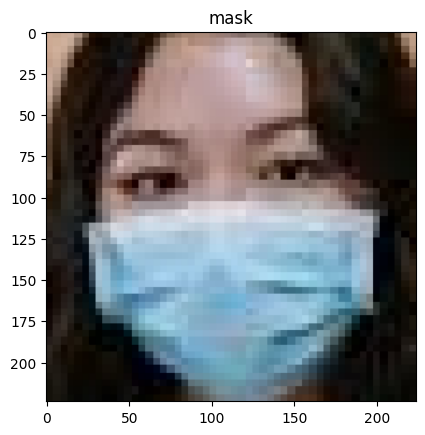

In [21]:
plt.imshow((test_X[0]/255.))
plt.title(name_class)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [23]:
import cv2

In [24]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
#     -O haarcascade_frontalface_default.xml

In [25]:
import cv2

1/1 [==============================] - 0s 60ms/step
[[ 6  8 69 69]]


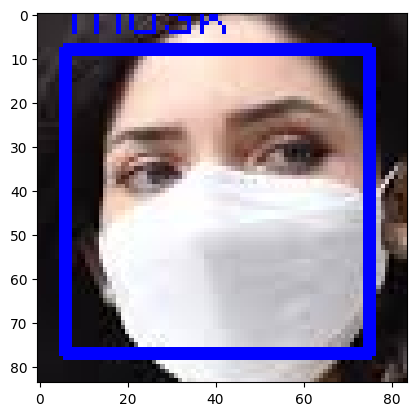

In [28]:
def detection_image_mask(img_path):
  # read img 
  test_image = cv2.imread(img_path)
  # convert to grayscale
  gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
  
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  #detect face
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  #predict mask or not mask
  crop =cv2.resize(test_image,(224,224))
  result = model_loaded.predict(tf.expand_dims(crop,0))
  name_class = name_classes[result.argmax()]
  print(faces)
  # draw the rect around each face and put text 
  (x,y,w,h)  = faces[0].astype('int')
  cv2.putText(test_image,name_class,(x,y-4),cv2.FONT_HERSHEY_SIMPLEX,0.45,(255,0,0),1)
  cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
    # cv2.putText(test_image,name_class,(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,cv2.LINE_AA,2)
  plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
detection_image_mask("./dataset/with mask/9.png")

1/1 [==============================] - 0s 74ms/step
[[ 9 10 89 89]]


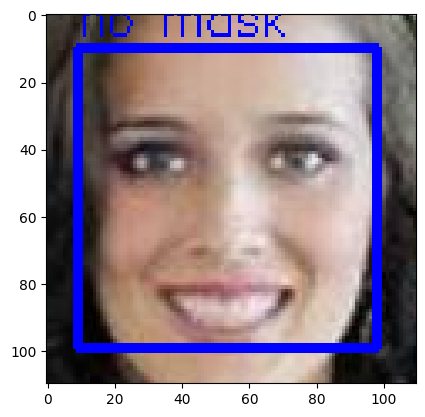

In [29]:
detection_image_mask("./dataset/without mask/19.png")

1/1 [==============================] - 0s 69ms/step
[[14 10 88 88]]


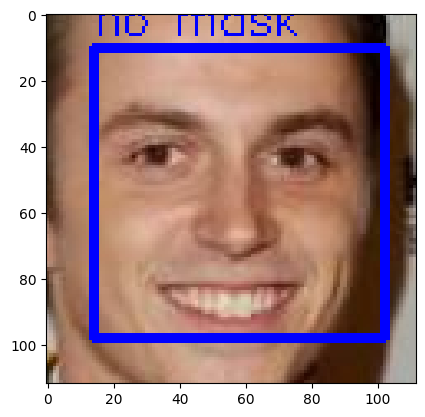

In [30]:
detection_image_mask("./dataset/without mask/27.png")

In [32]:

import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# To capture video from webcam. 
cap = cv2.VideoCapture(0)
# To use a video file as input 
# cap = cv2.VideoCapture('filename.mp4')

while True:
    # Read the frame
    ret, img = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # Draw the rectangle around each face and predict mask or not mask 

    for (x, y, w, h) in faces:
        crop =cv2.resize(img,(224,224))
        result = model_loaded.predict(tf.expand_dims(crop,0))
        name_class = name_classes[result.argmax()]
        cv2.putText(img,name_class,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,(255,0,0),2)
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display
    cv2.imshow('img', img)
    # Stop if escape key is pressed
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
# Release the VideoCapture object
cap.release()

1/1 [==============================] - 0s 64ms/step


: 